In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
# from functions import *

In [61]:
# define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [62]:
## EOSC410 Project
## Authors: Vanessa Yau + Christina Rutherford
saveIt = 0 # set to 1 to save all figs

# import avalanche data for sea-to-sky region
avy_risk = pd.read_csv('sea-to-sky_JanApr_2017_avy.csv') #TODO do we need to normalize this data?
avy_date = avy_risk['Date']
below_tree = avy_risk['Below Treeline']; below_tree = np.array(below_tree)
tree = avy_risk['Treeline']; tree = np.array(tree)
above_tree = avy_risk['Above Treeline']; above_tree = np.array(above_tree)

# import era5 2m temp data
temp_2m = np.load('Sea-to-Sky_JanApr_2017_Temp2m.npy')
snowdep = np.load('Sea-to-Sky_JanApr_2017_SnowDepth.npy')

# import era5 coordinates
# coord = np.load('Sea-to-Sky_JanFeb2017_LatLon.npy', allow_pickle=True)
# lat = coord[0]
# lon = coord[1]

#Current Temp and Snow Depth data are (31, 7, 13). I averaged them below to be (31,) and eventually reshape them to (31,1), but this still 
#causes the variance to only be 1 mode in the center. Therefore maybe we don't do PCA 

# averaging TEMP from (31,7,13) to (31, 7)
temp_station_mean = np.mean(temp_2m,axis=2)
# averaging TEMP from (31,7) to (31,1)
temp_mean = np.mean(temp_station_mean,axis=1)
# averaging SNOW from (31, 7, 13) to (31, 7)
snowdep_station_mean = np.mean(snowdep,axis=2)
# averaging SNOW from (31, 7) to (31, 1)
snowdep_mean = np.mean(snowdep_station_mean,axis=1)

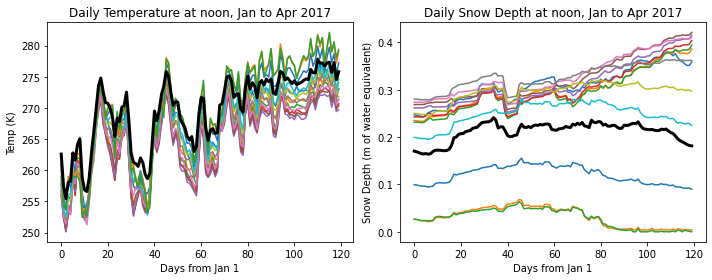

In [64]:
# visualize current temp and snow depth data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(temp_2m[:,1])
plt.plot(temp_mean, color = 'k',label = 'mean', linewidth = 3)
plt.xlabel('Days from Jan 1') # TODO fix axes label
plt.ylabel('Temp (K)')
plt.title('Daily Temperature at noon, Jan to Apr 2017')

plt.subplot(1,2,2)
plt.plot(snowdep[:,1])
plt.plot(snowdep_mean, color = 'k',label = 'mean', linewidth = 3)
plt.xlabel('Days from Jan 1')
plt.ylabel('Snow Depth (m of water equivalent)')
plt.title('Daily Snow Depth at noon, Jan to Apr 2017')

plt.tight_layout()
# plt.show()
if saveIt:
    plt.savefig('fig_JanApr2017_temp_snowdep.png')

In [65]:
# normalize data
temp_norm = (temp_mean - temp_mean.mean())/temp_mean.std()
snowdep_norm = (snowdep_mean - snowdep_mean.mean())/snowdep_mean.std()
# reshape data from (31,) to (31, 1)
temp_norm=temp_norm.reshape(-1, 1)
snowdep_norm=snowdep_norm.reshape(-1, 1)

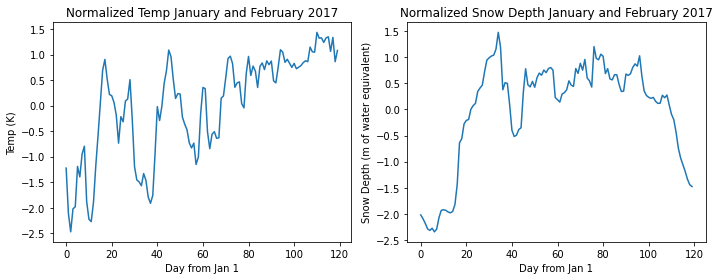

In [66]:
#visualize normalized data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(temp_norm)
#plt.plot(temp_mean, color = 'k',label = 'mean', linewidth = 3)
plt.xlabel('Day from Jan 1')
plt.ylabel('Temp (K)')
plt.title('Normalized Temp January and February 2017')

plt.subplot(1,2,2)
plt.plot(snowdep_norm)
#plt.plot(snowdep_mean, color = 'k',label = 'mean', linewidth = 3)
plt.xlabel('Day from Jan 1')
plt.ylabel('Snow Depth (m of water equivalent)')
plt.title('Normalized Snow Depth January and February 2017')

plt.tight_layout()
# plt.show()
if saveIt == 1:
    plt.savefig('fig_JanFeb2017_normalized_temp_snowdep.png')

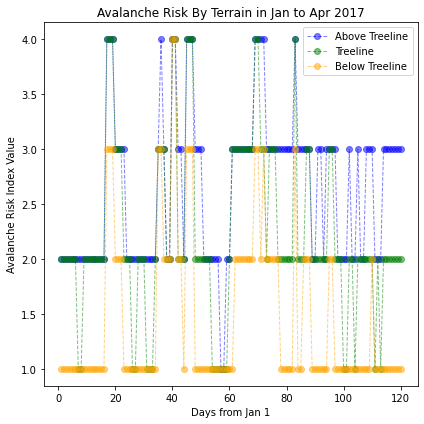

In [77]:
# plot avy risk data
days = np.linspace(1,len(avy_date),len(avy_date))
plt.figure(figsize=(6,6))
plt.plot(days,above_tree,color='blue',label='Above Treeline',alpha=0.5,marker='o',linewidth=1,linestyle='dashed')
plt.plot(days,tree,color='green',label='Treeline',alpha=0.5,marker='o',linewidth=1,linestyle='dashed')
plt.plot(days,below_tree,color='orange',label='Below Treeline',alpha=0.5,marker='o',linewidth=1, linestyle='dashed')
plt.legend()
plt.xlabel('Days from Jan 1')
plt.ylabel('Avalanche Risk Index Value')
plt.title('Avalanche Risk By Terrain in Jan to Apr 2017')

plt.tight_layout()
if saveIt == 1:
    plt.savefig('fig_JanApr2017_avyrisk.png')

In [ ]:
# turn data into one hot vectors for categorical model
# below treeline
enc_bt = OneHotEncoder(max_categories=5).fit(below_tree.values.reshape(-1,1))
enc_bt.categories_
bt_cat = enc_bt.transform(below_tree.values.reshape(-1,1)).toarray()

# if len(bt_cat[0,:]) != 5: # checks that output has 5 categories, otherwise adds colums of zeros
#     start = len(bt_cat[0,:])
#     end = 5
#     diff = end-start
#     addto = len(bt_cat[:,0])
#     for c in range(0,diff):
#         bt_cat = np.c_[bt_cat, np.zeros(addto)]


In [ ]:
# ready for MLP, see MLP file
# define variables for MLP
N = len(days) # size of data
n_predictors = 2
predictors = np.c_[temp_norm,snowdep_norm]

target_bt = bt_cat
target_t = tree
target_at = above_tree
target = [target_bt, target_t, target_at]

# loop through the 3 terrain categories for MLP on each
fracTrain = 0.8 # 80% of data used for training
NTrain = int(np.floor(fracTrain*N))
for m in range(0,2): 
    # target_m = target[m]
    target_m = target_bt
    x_train = predictors[:NTrain]
    y_train = target_m[:NTrain]

    x_test = predictors[NTrain:]
    y_test = target_m[NTrain:]

    # y_out_ensemble_mean, y_out_ensemble, RMSE_ensemble_mean, RMSE_ensemble, nhn_best, nhl_best = MLP(x_train,y_train,x_test,y_test)

    num_models = 10 #number of models to build for the ensemble
    min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
    max_nhn = 8 #maximum number of hidden neurons to loop through
    max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
    batch_size = 32
    solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
    activation = 'relu' # TODO try 'softmax' since we are dealing with multiclasses... changed from 'relu'
    learning_rate_init = 0.001

    max_iter = 1500 #max number of epochs to run
    early_stopping = True #True = stop early if validation error begins to rise
    validation_fraction = 0.1 #fraction of training data to use as validation

    y_out_all_nhn = []
    y_out_ensemble = []
    RMSE_ensemble = [] #RMSE for each model in the ensemble
    RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
    nhn_best = []
    nhl_best = []

    for model_num in range(num_models): #for each model in the ensemble
        
        # print('Model Number: ' + str(model_num))
        
        RMSE = []
        y_out_all_nhn = []
        nhn = []
        nhl = []
        
        for num_hidden_layers in range(1,max_hidden_layers+1):
        
            # print('\t # Hidden Layers = ' + str(num_hidden_layers))
        
            for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

                # print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
                
                hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                    verbose=False,
                                    max_iter=max_iter, 
                                    early_stopping = early_stopping,
                                    validation_fraction = validation_fraction,
                                    batch_size = batch_size,
                                    solver = solver,
                                    activation = activation,
                                    learning_rate_init = learning_rate_init)

                model.fit(x_train,y_train) #train the model

                y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
                y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

                RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
                
                nhn.append(num_hidden_neurons)
                nhl.append(num_hidden_layers)
            
        indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
        RMSE_ensemble.append(np.min(RMSE))
        nhn_best.append(nhn[indBest])
        nhl_best.append(nhl[indBest])
        #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
        y_out_ensemble.append(y_out_all_nhn[indBest])
        
        # print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
        
    y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
    RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)


In [ ]:
# transform y output back to categorical 1D array
bt_model = enc_bt.inverse_transform(y_test)

In [ ]:
# plot models only
plt.scatter(days[NTrain:],below_tree[NTrain:],alpha=0.8,marker='*',color='b')
plt.scatter(days[NTrain:],bt_model,alpha=0.8,color='b')
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Avalanche Danger Rating', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()
if saveIt:
    plt.savefig(f'fig_Jan2017_model_results_{m}.png')

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.scatter(days[NTrain:],below_tree[NTrain:],alpha=0.8,marker='*',color='b')
plt.scatter(days[NTrain:],bt_model,alpha=0.8,color='b')
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Avalanche Danger Rating', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()
if saveIt:
    plt.savefig(f'fig_Jan2017_model_results_{m}.png')